In [19]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import numpy.linalg as npla
import os
import scipy
import scipy.linalg as sla
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
%matplotlib inline

from methods.saddle import DecentralizedSaddleSliding, Extragradient, extragradient_solver, Logger, \
    ConstraintsL2, LoggerDecentralized
from methods.runners import DecentralizedExtragradientGTRunner, DecentralizedSaddleSlidingRunner, compute_lam_2
from oracles.saddle import ArrayPair, RobustLinearOracle, create_robust_linear_oracle, \
    OracleLinearComb

from experiment_utils import gen_matrices_decentralized, compute_robust_linear_normed_L_delta_mu, \
    line_adj_mat, ring_adj_mat, grid_adj_mat, metropolis_weights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
extragrad_loggers = defaultdict(dict)
extragrad_con_loggers = defaultdict(dict)
sliding_loggers = defaultdict(dict)

for graph in ['ring', 'grid', 'star']:
    with open('./logs/{}_nodes=25_noise=1.00e-04/extragrad_th.pkl'.format(graph), 'rb') as f:
        extragrad_loggers[graph][0.0001] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e-03/extragrad_th.pkl'.format(graph), 'rb') as f:
        extragrad_loggers[graph][0.001] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e-02/extragrad_th.pkl'.format(graph), 'rb') as f:
        extragrad_loggers[graph][0.01] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e-01/extragrad_th.pkl'.format(graph), 'rb') as f:
        extragrad_loggers[graph][0.1] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e+00/extragrad_th.pkl'.format(graph), 'rb') as f:
        extragrad_loggers[graph][1] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e+01/extragrad_th.pkl'.format(graph), 'rb') as f:
        extragrad_loggers[graph][10] = pickle.load(f)

    with open('./logs/{}_nodes=25_noise=1.00e-04/sliding_th.pkl'.format(graph), 'rb') as f:
        sliding_loggers[graph][0.0001] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e-03/sliding_th.pkl'.format(graph), 'rb') as f:
        sliding_loggers[graph][0.001] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e-02/sliding_th.pkl'.format(graph), 'rb') as f:
        sliding_loggers[graph][0.01] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e-01/sliding_th.pkl'.format(graph), 'rb') as f:
        sliding_loggers[graph][0.1] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e+00/sliding_th.pkl'.format(graph), 'rb') as f:
        sliding_loggers[graph][1] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e+01/sliding_th.pkl'.format(graph), 'rb') as f:
        sliding_loggers[graph][10] = pickle.load(f)


    with open('./logs/{}_nodes=25_noise=1.00e-04/extragrad_con_th.pkl'.format(graph), 'rb') as f:
        extragrad_con_loggers[graph][0.0001] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e-03/extragrad_con_th.pkl'.format(graph), 'rb') as f:
        extragrad_con_loggers[graph][0.001] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e-02/extragrad_con_th.pkl'.format(graph), 'rb') as f:
        extragrad_con_loggers[graph][0.01] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e-01/extragrad_con_th.pkl'.format(graph), 'rb') as f:
        extragrad_con_loggers[graph][0.1] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e+00/extragrad_con_th.pkl'.format(graph), 'rb') as f:
        extragrad_con_loggers[graph][1] = pickle.load(f)
    with open('./logs/{}_nodes=25_noise=1.00e+01/extragrad_con_th.pkl'.format(graph), 'rb') as f:
        extragrad_con_loggers[graph][10] = pickle.load(f)

with open("./logs/ring_nodes=25_noise=1.00e-02/extragrad_stepsize=0.001.pkl", "rb") as f:
    extragrad_custom = pickle.load(f)

In [31]:
def plot_sliding_egd(graph: str, noise: float, save_to=None):
    plt.figure(figsize=(12, 6))

    extragrad_logger = extragrad_loggers[graph][noise]
    extragrad_con_logger = extragrad_con_loggers[graph][noise]
    sliding_logger = sliding_loggers[graph][noise]

    comm_budget = extragrad_logger.comm_budget
    comm_steps_sliding = np.arange(0, comm_budget + 1, sliding_logger.comm_per_iter)
    comm_steps_extragrad = np.arange(0, comm_budget + 1, 2)
    comm_steps_extragrad_con = np.arange(0, comm_budget + 1, extragrad_con_logger.comm_per_iter)

    plt.suptitle('{} graph, 25 nodes, noise = {}'.format(graph, noise), fontsize=25)

    plt.subplot(121)
    ax = plt.gca()
    ax.plot(comm_steps_sliding, sliding_logger.dist_to_opt, label='Alg. 2', marker='o', markevery=0.15)
    ax.plot(comm_steps_extragrad, extragrad_logger.dist_to_opt, label='EGD-GT', marker='^', markevery=0.15)
    ax.plot(comm_steps_extragrad_con, extragrad_con_logger.dist_to_opt, label='EGD', marker='v', markevery=0.15)
    ax.set_xlabel('communications', fontsize=22)
    ax.set_ylabel('$||\overline{z}-z^*||^2$', fontsize=22)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.tick_params(labelsize=15)
    ax.xaxis.get_offset_text().set_size(15)
    ax.set_yscale('log')
    ax.legend(fontsize=16, loc='lower left')
    ax.grid()

    plt.subplot(122)
    ax = plt.gca()
    ax.plot(comm_steps_sliding[0:], sliding_logger.dist_to_con[0:], label='Alg. 2', marker='o', markevery=0.15)
    ax.plot(comm_steps_extragrad[0:], extragrad_logger.dist_to_con[0:], label='EGD-GT', marker='^', markevery=0.15)
    ax.plot(comm_steps_extragrad_con[0:], extragrad_con_logger.dist_to_con[0:], label='EGD', marker='v', markevery=0.15)
    ax.set_xlabel('communications', fontsize=22)
    ax.set_ylabel('dist. to consensus', fontsize=22)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.tick_params(labelsize=15)
    ax.xaxis.get_offset_text().set_size(15)
    ax.set_yscale('log')
    ax.legend(fontsize=16, loc='lower right')
    ax.grid()

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    
    if save_to is not None:
        plt.savefig(save_to)
        plt.close()
    else:
        plt.show()


def save_figs_sliding_egd():
    for graph in ['ring', 'grid', 'star']:
        for noise in [0.0001, 0.001, 0.01, 0.1, 1., 10.]:
            folder = '../../figures/decentralized/{}_25_nodes'.format(graph)
            os.system('mkdir -p {}'.format(folder))
            plot_sliding_egd(graph, noise, '{}/noise={}.png'.format(folder, noise))

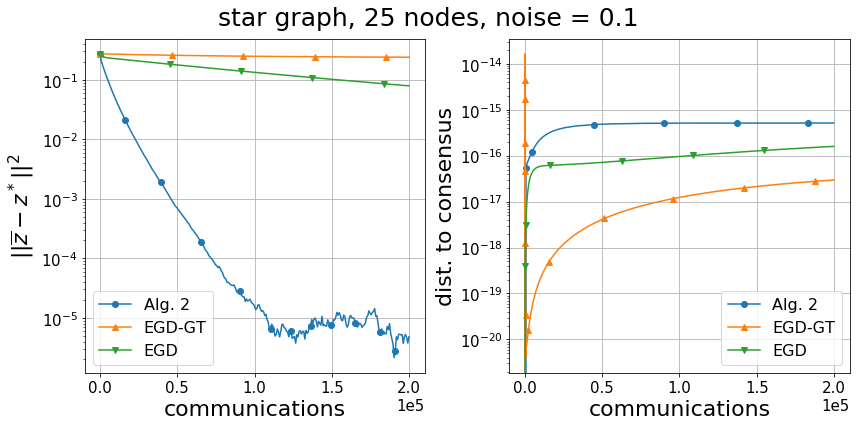

In [32]:
plot_sliding_egd('star', 0.1)

In [33]:
save_figs_sliding_egd()

In [34]:
def plot_sliding_different_noise(graph: str, save_to=None):
    plt.figure(figsize=(12, 6))

    plt.suptitle('{} graph, 25 nodes'.format(graph), fontsize=25)

    plt.subplot(121)
    ax = plt.gca()
    for noise, marker in zip([0.001, 0.01, 0.1, 1.], ['o', 'v', '^', 's']):
        sliding_logger = sliding_loggers[graph][noise]
        comm_budget = sliding_logger.comm_budget
        comm_steps_sliding = np.arange(0, comm_budget + 1, sliding_logger.comm_per_iter)
        ax.plot(comm_steps_sliding, sliding_logger.dist_to_opt, label='noise={}'.format(noise), marker=marker, markevery=0.15)

    ax.set_xlabel('communications', fontsize=22)
    ax.set_ylabel('$||\overline{z}-z^*||^2$', fontsize=22)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.tick_params(labelsize=15)
    ax.xaxis.get_offset_text().set_size(15)
    ax.set_yscale('log')
    ax.legend(fontsize=16, loc='lower left')
    ax.grid()

    plt.subplot(122)
    ax = plt.gca()
    for noise, marker in zip([0.001, 0.01, 0.1, 1.], ['o', 'v', '^', 's']):
        sliding_logger = sliding_loggers[graph][noise]
        comm_budget = sliding_logger.comm_budget
        comm_steps_sliding = np.arange(0, comm_budget + 1, sliding_logger.comm_per_iter)
        ax.plot(comm_steps_sliding[::10], sliding_logger.dist_to_con[::10], label='noise={}'.format(noise), marker=marker, markevery=0.1)

    ax.set_xlabel('communications', fontsize=22)
    ax.set_ylabel('dist. to consensus', fontsize=22)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.tick_params(labelsize=15)
    ax.xaxis.get_offset_text().set_size(15)
    ax.set_yscale('log')
    ax.legend(fontsize=16, loc='lower right')
    ax.grid()

    plt.tight_layout(rect=[0, 0, 1, 0.93])
        
    if save_to is not None:
        plt.savefig(save_to)
        plt.close()
    else:
        plt.show()


def save_figs_sliding_different_noise():
    for graph in ['ring', 'grid', 'star']:
        folder = '../../figures/decentralized/sliding_different_noise'
        os.system('mkdir -p {}'.format(folder))
        plot_sliding_different_noise(graph, '{}/graph={}.png'.format(folder, graph))

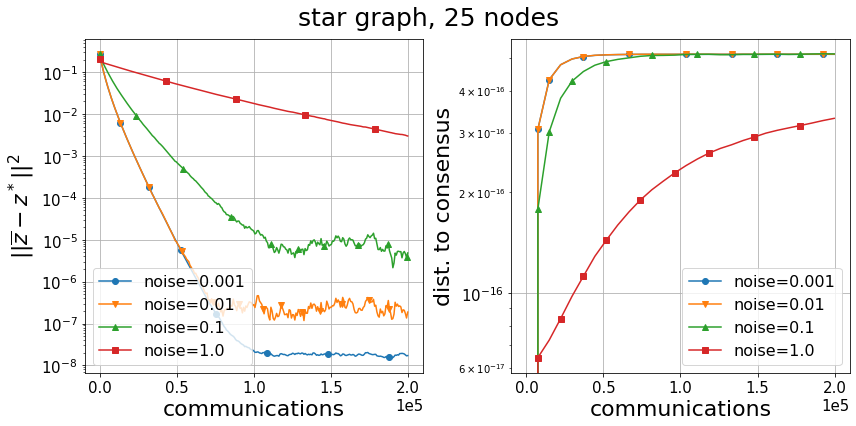

In [36]:
plot_sliding_different_noise('star', save_to=None)

In [37]:
save_figs_sliding_different_noise()